Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [4]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [5]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [6]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [7]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [8]:
df.isnull().sum()

Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 

In [9]:
df.shape

(421, 59)

With 421 observations, we can see that many of these variables simply do not contain much information (are 90+% missing values). It also looks like some may be partially encoded within other variables. I also drop date (in theory, this should not affect burrito quality, though there are arguments that it's worth checking this in a more formal analysis). For the time being, let's generate a subset with these features:

In [10]:
features = ["Burrito", "Cost", "Hunger", "Length", "Circum", 
            "Tortilla", "Temp", "Meat", "Fillings", "Uniformity", 
            "Salsa","Synergy", "Wrap"]
target = "Great"

In [11]:
df.dtypes

Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

In [12]:
# Cast date as datetime
df["Date"] = pd.to_datetime(df["Date"])

In [13]:
train = df[df["Date"].dt.year <= 2016]
val = df[df["Date"].dt.year == 2017]
test = df[df["Date"].dt.year == 2018]

In [14]:
train["Great"].mean()

0.40939597315436244

It looks like 40.9% of burritos in our training set were rated as "Great". Thus, a naive model simply predicting "Not Great" for every burrito would hit 59.1% accuracy. Let's see if we can beat that score!

In [15]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [16]:
X_train.shape, y_train.shape

((298, 13), (298,))

In [17]:
X_train.head()

,Burrito,Cost,Hunger,Length,Circum,Tortilla,Temp,Meat,Fillings,Uniformity,Salsa,Synergy,Wrap
0,California,6.49,3.0,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0
1,California,5.45,3.5,NaN,NaN,2.0,3.5,2.5,2.5,4.0,3.5,2.5,5.0
2,Carnitas,4.85,1.5,NaN,NaN,3.0,2.0,2.5,3.0,4.0,3.0,3.0,5.0
3,Asada,5.25,2.0,NaN,NaN,3.0,2.0,3.5,3.0,5.0,4.0,4.0,5.0
4,California,6.59,4.0,NaN,NaN,4.0,5.0,4.0,3.5,5.0,2.5,4.5,4.0


In [18]:
X_train[["Length", "Circum"]].describe()

,Length,Circum
count,175.000000,174.000000
mean,19.829886,22.042241
std,2.081275,1.685043
min,15.000000,17.000000
25%,18.500000,21.000000
50%,19.500000,22.000000
75%,21.000000,23.000000
max,26.000000,27.000000


In [19]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names = True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

It looks like we have a substantial number of null values in length and circumference. Let's impute those with the mean of the data so we can use the data from the rows where we do have values in order to explore any relationship. Mean seems like a fair imputation; I speculate that people not including these values did so out of laziness rather than due to any pattern.

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.fit_transform(X_val_imputed)

In [22]:
pd.DataFrame(X_train_scaled, columns = X_train_encoded.columns).head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Cost,Hunger,Length,Circum,Tortilla,Temp,Meat,Fillings,Uniformity,Salsa,Synergy,Wrap
0,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-0.339805,-0.524307,0.0,0.0,-0.593162,1.340696,-0.645992,-0.022447,0.557478,0.721245,0.500993,0.038686
1,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-1.208571,0.064423,0.0,0.0,-1.849023,-0.213867,-1.231964,-1.202403,0.557478,0.187274,-1.133401,0.899679
2,-0.809664,4.503967,-0.364801,-0.764922,-0.27534,-1.709783,-2.290496,0.0,0.0,-0.593162,-1.768429,-1.231964,-0.612425,0.557478,-0.346697,-0.588603,0.899679
3,-0.809664,-0.222027,2.741220,-0.764922,-0.27534,-1.375642,-1.701766,0.0,0.0,-0.593162,-1.768429,-0.060021,-0.612425,1.480371,0.721245,0.500993,0.899679
4,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-0.256270,0.653153,0.0,0.0,0.662698,1.340696,0.525950,-0.022447,1.480371,-0.880668,1.045791,0.038686


In [23]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)
print('Training Accuracy', model.score(X_train_scaled, y_train))

Training Accuracy 0.8859060402684564


88% accuracy on our training set. Not bad -- quite a bit better than guessing! Let's see if that accuracy holds up on our validation set.

In [24]:
print("Validation Accuracy", model.score(X_val_scaled, y_val))

Validation Accuracy 0.8588235294117647


85% accuracy on the validation set -- still not bad!

In [25]:
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_test_pred = model.predict(X_test_scaled)

In [26]:
model.score(X_test_scaled, y_test)

0.7037037037037037

In [27]:
y_train.shape, y_val.shape, y_test.shape

((298,), (85,), (27,))

Our model only scored 70.4% on the test set. That's fairly disappointing. However, this could be due to simple negative variance -- the test set only had 27 observations, making a precise estimate of model strength difficult. 

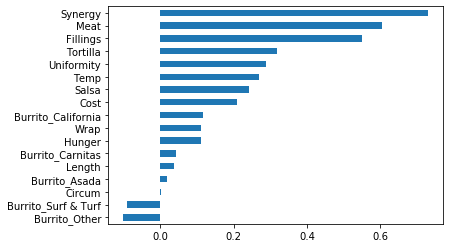

In [28]:
coords = pd.Series(model.coef_[0], X_train_encoded.columns)
coords.sort_values().plot.barh();

"Synergy," meat, and fillings were the most important factors in a great burrito. I have substantial concern that information from the X variable is leaking into the Y variable here -- "synergy" is a metric of what makes burritos greater than the sum of their parts, which, uh, seems like much like the subjective assessment of "a great burrito" -- but I digress. California was the most popular burrito, with "Surf and Turf" and "Other" bringing up the rear. 